In [ ]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install tensorflow_data_validation

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sklearn as sk
import scipy as sp
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import clear_output
from matplotlib import pyplot as plt
from shapely import wkt

2022-12-15 01:57:00.275052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 01:57:00.400141: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('/tf')
PGUSER = os.getenv('POSTGRES_USER')
PGPW = os.getenv('POSTGRES_PW')
PGDB = os.getenv('POSTGRES_DB')
NULLFLAG = -9999
ONEDAY = 24 * 60 * 60
WEEK = 7 * ONEDAY

In [ ]:
# load firewaterelev
fireWaterElev = "Data/FireWaterElev.csv"
dfFireWaterElev = pd.read_csv(fireWaterElev)

In [ ]:
print(dfFireWaterElev.count())
print(dfFireWaterElev.describe())
print(dfFireWaterElev.isnull().sum().sum())

EntryID          428
FIRE_ID          428
FIRENAME         428
YEAR             428
MONTH            428
DAY              428
REP_DATE         428
SIZE_HA          428
size_ha_bin      428
ClimateID        428
ElevationM       428
Dist_To_Water    428
utc              428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.0 428.0    428.0        428.0       428.0   
mean    3829.2 2013.9    6.8  15.9   8936.9          1.7       883.5   
std     3843.2    2.6    0.9   9.8  32731.6          1.1       460.7   
min       33.0 2010.0    5.0   1.0    200.7          0.0       334.0   
25%      757.5 2012.0    6.0   6.0    651.8          1.0       457.8   
50%     1736.0 2014.0    7.0  15.0   1880.7          2.0       787.5   
75%     8700.2 2016.0    7.0  25.2   5092.8          3.0      1280.0   
max    12248.0 2020.0   10.0  31.0 491429.4          3.0      1952.0   

       Dist_To_Water          utc  
count          428.0        4

In [ ]:
def getGPDfromPD(df: pd.DataFrame, geomCol: str, crs: str = "EPSG:3978") -> gpd.GeoDataFrame:
    """
    Convert a pandas dataframe to a geopandas dataframe
    :param df: pandas dataframe
    :param geomCol: name of the geometry column
    :param crs: coordinate reference system
    :return: geopandas dataframe
    """
    if 'geom' in df.columns:
        df.rename(columns={'geom': 'geometry'}, inplace=True)

    df[geomCol] = df[geomCol].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry=geomCol, crs=crs)
    return gdf

In [ ]:
# load fire centroids 
fireCentroids = "Data/GEOlgFireFiftyCentroids.csv"
dfTemp = pd.read_csv(fireCentroids)

dfCentroids = getGPDfromPD(dfTemp, 'geometry')
print(dfCentroids.columns)

Index(['EntryID', 'geometry'], dtype='object')


In [ ]:
dfTemp = dfCentroids.merge(dfFireWaterElev, on='EntryID', how='inner')
# dfTemp = dfFireWaterElevGPD.merge(dfCentroids, on='EntryID', how='left')

print(dfTemp.columns)
dfFireWECent = dfTemp

print(dfFireWECent.count())
print(dfFireWECent.columns)
print(dfFireWECent.head())

Index(['EntryID', 'geometry', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY',
       'REP_DATE', 'SIZE_HA', 'size_ha_bin', 'ClimateID', 'ElevationM',
       'Dist_To_Water', 'utc'],
      dtype='object')
EntryID          428
geometry         428
FIRE_ID          428
FIRENAME         428
YEAR             428
MONTH            428
DAY              428
REP_DATE         428
SIZE_HA          428
size_ha_bin      428
ClimateID        428
ElevationM       428
Dist_To_Water    428
utc              428
dtype: int64
Index(['EntryID', 'geometry', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY',
       'REP_DATE', 'SIZE_HA', 'size_ha_bin', 'ClimateID', 'ElevationM',
       'Dist_To_Water', 'utc'],
      dtype='object')
   EntryID                         geometry FIRE_ID                 FIRENAME  \
0       33  POINT (5034115.756 2378216.407)  LWF116      Cowper Complex Fire   
1       38  POINT (5042482.245 2388004.248)  LWF123        Kettle River Fire   
2       40  POINT (5042593.050 2355098.687)  LW

In [ ]:
# join firewaterelev and firecentroids using EntryID
# dfFireWECent = dfFireCentroids.merge(dfFireWaterElev, on='EntryID', how='left')

In [ ]:
# print(dfFireWECent.columns)
# print(dfFireWECent.count())

In [ ]:
stations = "Data/GEOTenYrStationsHourly.csv"
dfTemp = pd.read_csv(stations)

dfStations = getGPDfromPD(dfTemp, 'geometry')

In [ ]:
# dfFireWECent.drop(columns=['ClimateID'], inplace=True)

# keep only Province == SASKATCHEWAN
dfStations = dfStations[dfStations['Province'] == 'SASKATCHEWAN']
dfStations.drop(columns=['dataAvailable'], inplace=True)
print(dfStations.columns)
print(dfStations.head())

Index(['Province', 'StationName', 'ClimateID', 'HLYFirstYear', 'HLYLastYear',
       'distance', 'geometry'],
      dtype='object')
        Province            StationName ClimateID  HLYFirstYear  HLYLastYear  \
47  SASKATCHEWAN  BUFFALO NARROWS (AUT)   4060983        1994.0       2022.0   
48  SASKATCHEWAN      BUFFALO NARROWS A   4060988        2014.0       2022.0   
49  SASKATCHEWAN      BUFFALO NARROWS A   4060982        1979.0       2012.0   
63  SASKATCHEWAN      BUFFALO NARROWS A   4060984        2012.0       2019.0   
98  SASKATCHEWAN            COLLINS BAY   4061629        1994.0       2015.0   

    distance                         geometry  
47   25069.7  POINT (5196011.335 2312830.492)  
48   25069.7  POINT (5196011.335 2312830.492)  
49   23824.9  POINT (5195137.903 2311934.989)  
63   25069.7  POINT (5196011.335 2312830.492)  
98     957.0  POINT (5525017.364 2500073.179)  


In [ ]:

# gpd sjoin to find nearest station to each fire
dfNearest = gpd.sjoin_nearest(dfFireWECent, dfStations, how='left', max_distance=117590)
print(dfNearest.count())
print(dfNearest.columns)
print(dfNearest.head()) 

EntryID            580
geometry           580
FIRE_ID            580
FIRENAME           580
YEAR               580
MONTH              580
DAY                580
REP_DATE           580
SIZE_HA            580
size_ha_bin        580
ClimateID_left     580
ElevationM         580
Dist_To_Water      580
utc                580
index_right        429
Province           429
StationName        429
ClimateID_right    429
HLYFirstYear       429
HLYLastYear        429
distance           429
dtype: int64
Index(['EntryID', 'geometry', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY',
       'REP_DATE', 'SIZE_HA', 'size_ha_bin', 'ClimateID_left', 'ElevationM',
       'Dist_To_Water', 'utc', 'index_right', 'Province', 'StationName',
       'ClimateID_right', 'HLYFirstYear', 'HLYLastYear', 'distance'],
      dtype='object')
   EntryID                         geometry FIRE_ID                 FIRENAME  \
0       33  POINT (5034115.756 2378216.407)  LWF116      Cowper Complex Fire   
1       38  POINT (504248

In [ ]:
# drop rows with nan values
dfNearest.dropna(inplace=True)
print(dfNearest.count())
print(dfNearest.columns)
print(dfNearest.head()) 


EntryID            429
geometry           429
FIRE_ID            429
FIRENAME           429
YEAR               429
MONTH              429
DAY                429
REP_DATE           429
SIZE_HA            429
size_ha_bin        429
ClimateID_left     429
ElevationM         429
Dist_To_Water      429
utc                429
index_right        429
Province           429
StationName        429
ClimateID_right    429
HLYFirstYear       429
HLYLastYear        429
distance           429
dtype: int64
Index(['EntryID', 'geometry', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY',
       'REP_DATE', 'SIZE_HA', 'size_ha_bin', 'ClimateID_left', 'ElevationM',
       'Dist_To_Water', 'utc', 'index_right', 'Province', 'StationName',
       'ClimateID_right', 'HLYFirstYear', 'HLYLastYear', 'distance'],
      dtype='object')
    EntryID                         geometry   FIRE_ID             FIRENAME  \
3        43  POINT (5100527.629 2358329.642)    LWF175  Winefred River Fire   
6      3126  POINT (5603638

In [ ]:
dfNearest.drop(columns=['ClimateID_left'], inplace=True)
dfNearest.rename(columns={'ClimateID_right': 'ClimateID'}, inplace=True)

In [ ]:
# dfFireWEStations = dfFireWECent.copy( deep = True )

In [ ]:
# For each line in dfMerged, find the closest weather station and keep the name of that station
# for index, row in dfFireWECent.iterrows():
#     # find the closest weather station
#     closest = dfStations.distance(row['geometry']).idxmin()
#     dfFireWEStations.at[index, 'ClimateID'] = dfStations.at[closest, 'ClimateID']
# print(dfFireWEStations.columns)

In [ ]:
weatherDaily = "Data/WeatherDataHourlyAggDaily.csv"
dfWeatherDaily = pd.read_csv(weatherDaily)


/tmp/ipykernel_6638/2212878750.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfWeatherDaily = pd.read_csv(weatherDaily)


In [ ]:
print(dfWeatherDaily.count())
print(dfWeatherDaily.describe())
print(dfWeatherDaily.isnull().sum().sum())

ClimateID            72790
ProvinceCode         72790
Year                 72790
Month                72790
Day                  72790
MeanTemp             72790
MinTemp              72790
MaxTemp              72790
MeanDewPoint         71852
MinDewPoint          71852
MaxDewPoint          71852
MeanHumidity         71852
MinHumidity          71852
MaxHumidity          71852
MeanPressure         71487
MinPressure          71487
MaxPressure          71487
MeanWindSpeed        71487
MinWindSpeed         71487
MaxWindSpeed         71487
MeanWindChill        71487
MinWindChill         71487
MaxWindChill         71487
TotalPrecip          72790
MeanWindDirection    71487
utc                  72790
dtype: int64
         Year   Month     Day  MeanTemp  MinTemp  MaxTemp  MeanDewPoint  \
count 72790.0 72790.0 72790.0   72790.0  72790.0  72790.0       71852.0   
mean   2015.7     6.5    15.7      -0.4     -5.7      4.4          -5.6   
std       3.4     3.5     8.8      14.8     14.7     15.3   

In [ ]:
# rename dfWeatherDaily columns to use all caps for year month day
dfWeatherDaily.rename(columns={'climateid': 'ClimateID', 'Year': 'YEAR', 'Month': 'MONTH', 'Day': 'DAYw', 'utc': 'utcWeather'}, inplace=True)
print(dfWeatherDaily.columns)

Index(['ClimateID', 'ProvinceCode', 'YEAR', 'MONTH', 'DAYw', 'MeanTemp',
       'MinTemp', 'MaxTemp', 'MeanDewPoint', 'MinDewPoint', 'MaxDewPoint',
       'MeanHumidity', 'MinHumidity', 'MaxHumidity', 'MeanPressure',
       'MinPressure', 'MaxPressure', 'MeanWindSpeed', 'MinWindSpeed',
       'MaxWindSpeed', 'MeanWindChill', 'MinWindChill', 'MaxWindChill',
       'TotalPrecip', 'MeanWindDirection', 'utcWeather'],
      dtype='object')


In [ ]:
print(dfNearest.dtypes)
print(dfWeatherDaily.dtypes)

EntryID             int64
geometry         geometry
FIRE_ID            object
FIRENAME           object
YEAR                int64
MONTH               int64
DAY                 int64
REP_DATE           object
SIZE_HA           float64
size_ha_bin         int64
ElevationM        float64
Dist_To_Water     float64
utc                 int64
index_right       float64
Province           object
StationName        object
ClimateID          object
HLYFirstYear      float64
HLYLastYear       float64
distance          float64
dtype: object
ClimateID             object
ProvinceCode          object
YEAR                   int64
MONTH                  int64
DAYw                   int64
MeanTemp             float64
MinTemp              float64
MaxTemp              float64
MeanDewPoint         float64
MinDewPoint          float64
MaxDewPoint          float64
MeanHumidity         float64
MinHumidity          float64
MaxHumidity          float64
MeanPressure         float64
MinPressure          float64
Ma

In [ ]:
# dfAll = dfFireWECent.copy(deep=True)

# dfAll.rename(columns={'utc': 'utcFire'}, inplace=True)
# # left join dfAll and dfWeatherDaily on ClimateID and YEAR MONTH
# dfAll = dfAll.merge(dfWeatherDaily, on=['ClimateID', 'YEAR', 'MONTH', 'DAY'], how='left')


# print(dfAll.columns)
# print(dfFireWECent.count())
# print(dfAll.count())


In [ ]:
dfNearest.describe()


,EntryID,YEAR,MONTH,DAY,SIZE_HA,size_ha_bin,ElevationM,Dist_To_Water,utc,index_right,HLYFirstYear,HLYLastYear,distance
count,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0
mean,1611.2,2013.9,6.7,16.1,9701.6,1.7,769.7,3240.9,1402340475.5,257.6,1999.3,2020.7,11583.8
std,2279.9,2.4,0.9,9.7,25858.8,1.1,458.4,3452.3,76507193.3,188.1,14.3,2.8,10017.2
min,43.0,2010.0,5.0,1.0,211.4,0.0,334.0,0.0,1273622400.0,47.0,1959.0,2012.0,247.6
25%,365.0,2012.0,6.0,6.0,648.8,1.0,439.0,842.2,1341878400.0,63.0,1994.0,2022.0,413.0
50%,799.0,2015.0,7.0,17.0,2064.8,2.0,485.0,1870.8,1433635200.0,259.0,1999.0,2022.0,11623.8
75%,1716.0,2015.0,7.0,25.0,6031.9,3.0,1247.0,4311.7,1436054400.0,499.0,2012.0,2022.0,25069.7
max,12248.0,2020.0,10.0,31.0,178818.2,3.0,1926.0,16699.1,1593388800.0,553.0,2015.0,2022.0,25069.7


In [ ]:
dfNearest['ClimateID'] = dfNearest['ClimateID'].astype(str)
dfWeatherDaily['ClimateID'] = dfWeatherDaily['ClimateID'].astype(str)

In [ ]:
# join dfAll plus weather

dfAll = dfNearest.copy(deep=True)

dfAll.rename(columns={'utc': 'utcFire'}, inplace=True)
# left join dfAll and dfWeatherDaily on ClimateID and YEAR and MONTH
dfAll = dfAll.merge(dfWeatherDaily, on=['ClimateID', 'MONTH', 'YEAR'], how='left')
print(dfAll.head())
# keep only rows where utcWeather = utcFire - ONEDAY
dfAll = dfAll[(dfAll['DAYw'] == dfAll['DAY'] - 1)]

print(dfAll.columns)
print(dfNearest.count())
print(dfAll.count())

#testing



   EntryID                         geometry FIRE_ID             FIRENAME  \
0       43  POINT (5100527.629 2358329.642)  LWF175  Winefred River Fire   
1     3126  POINT (5603638.458 2257133.303)   NE044                NE044   
2     3126  POINT (5603638.458 2257133.303)   NE044                NE044   
3     3126  POINT (5603638.458 2257133.303)   NE044                NE044   
4     3126  POINT (5603638.458 2257133.303)   NE044                NE044   

   YEAR  MONTH  DAY    REP_DATE  SIZE_HA  size_ha_bin  ElevationM  \
0  2015      6   26  2015-06-26  11882.5            3       517.0   
1  2016      6   23  2016-06-23   1059.3            1      1280.0   
2  2016      6   23  2016-06-23   1059.3            1      1280.0   
3  2016      6   23  2016-06-23   1059.3            1      1280.0   
4  2016      6   23  2016-06-23   1059.3            1      1280.0   

   Dist_To_Water     utcFire  index_right      Province         StationName  \
0        14478.9  1435276800         49.0  SASKAT

In [ ]:
# print rows with NaN values
print(dfAll[dfAll.isna().any(axis=1)])

Empty GeoDataFrame
Columns: [EntryID, geometry, FIRE_ID, FIRENAME, YEAR, MONTH, DAY, REP_DATE, SIZE_HA, size_ha_bin, ElevationM, Dist_To_Water, utcFire, index_right, Province, StationName, ClimateID, HLYFirstYear, HLYLastYear, distance, ProvinceCode, DAYw, MeanTemp, MinTemp, MaxTemp, MeanDewPoint, MinDewPoint, MaxDewPoint, MeanHumidity, MinHumidity, MaxHumidity, MeanPressure, MinPressure, MaxPressure, MeanWindSpeed, MinWindSpeed, MaxWindSpeed, MeanWindChill, MinWindChill, MaxWindChill, TotalPrecip, MeanWindDirection, utcWeather]
Index: []


In [ ]:
# first read in the csv file into pd
dfTemp = pd.read_csv('Data/GEOProvincialBoundaries.csv')

dfProvinces = getGPDfromPD(dfTemp, 'geometry')

In [ ]:
# keep only dfNearest where geomtry is containe din dfProvinces Saskatchewan
dfAll['keep'] = False
for index, row in dfAll.iterrows():
    if dfProvinces[dfProvinces['provID'] == 'SK'].contains(row['geometry']).any():
        dfAll.at[index, 'keep'] = True


In [ ]:
print(dfAll.head())
print(dfAll.count())

     EntryID                         geometry   FIRE_ID  FIRENAME  YEAR  \
22      3126  POINT (5603638.458 2257133.303)     NE044     NE044  2016   
41        64  POINT (5206643.245 2773109.435)    MWF041    MWF041  2011   
75       297  POINT (5236947.906 2276507.245)  15LX-FOX  15LX-FOX  2015   
105      297  POINT (5236947.906 2276507.245)  15LX-FOX  15LX-FOX  2015   
135      297  POINT (5236947.906 2276507.245)  15LX-FOX  15LX-FOX  2015   

     MONTH  DAY    REP_DATE  SIZE_HA  size_ha_bin  ElevationM  Dist_To_Water  \
22       6   23  2016-06-23   1059.3            1      1280.0          787.0   
41       6   14  2011-06-14  15372.4            3      1060.0          356.1   
75       6   18  2015-06-18   1821.5            2       444.0         4311.7   
105      6   18  2015-06-18   1821.5            2       444.0         4311.7   
135      6   18  2015-06-18   1821.5            2       444.0         4311.7   

        utcFire  index_right      Province            StationName Cl

In [ ]:
dfAll = dfAll[dfAll['keep'] == True]
print(dfAll.head())
print(dfAll.count())

     EntryID                         geometry       FIRE_ID      FIRENAME  \
75       297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
105      297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
135      297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
162      298  POINT (5257196.797 2385760.520)  15BN-LDSAT01  15BN-LDSAT01   
193      298  POINT (5257196.797 2385760.520)  15BN-LDSAT01  15BN-LDSAT01   

     YEAR  MONTH  DAY    REP_DATE  SIZE_HA  size_ha_bin  ElevationM  \
75   2015      6   18  2015-06-18   1821.5            2       444.0   
105  2015      6   18  2015-06-18   1821.5            2       444.0   
135  2015      6   18  2015-06-18   1821.5            2       444.0   
162  2015      7   15  2015-07-15   4372.3            2       521.0   
193  2015      7   15  2015-07-15   4372.3            2       521.0   

     Dist_To_Water     utcFire  index_right      Province  \
75          4311.7  1434585600         47.0  SASK

In [ ]:
dfAll.drop(columns=['MeanTemp', 'MinTemp', 'MeanDewPoint', 'MinDewPoint', 'MaxDewPoint',
                    'MinHumidity', 'MaxHumidity', 'MeanPressure', 'MinPressure',
                    'MaxPressure', 'MinWindSpeed', 'MeanWindChill', 'MinWindChill', 'MaxWindChill',
                    'MeanWindDirection' ], inplace=True)

In [ ]:
dfRain = dfAll.copy(deep = True)
dfRain['Rain'] = (dfRain['TotalPrecip'] > 0).astype(bool)

In [ ]:
dfRain['Longitude'] = dfRain['geometry'].x
dfRain['Latitude'] = dfRain['geometry'].y
print(dfRain.head())
print(dfRain.count())

     EntryID                         geometry       FIRE_ID      FIRENAME  \
75       297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
105      297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
135      297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
162      298  POINT (5257196.797 2385760.520)  15BN-LDSAT01  15BN-LDSAT01   
193      298  POINT (5257196.797 2385760.520)  15BN-LDSAT01  15BN-LDSAT01   

     YEAR  MONTH  DAY    REP_DATE  SIZE_HA  size_ha_bin  ElevationM  \
75   2015      6   18  2015-06-18   1821.5            2       444.0   
105  2015      6   18  2015-06-18   1821.5            2       444.0   
135  2015      6   18  2015-06-18   1821.5            2       444.0   
162  2015      7   15  2015-07-15   4372.3            2       521.0   
193  2015      7   15  2015-07-15   4372.3            2       521.0   

     Dist_To_Water     utcFire  index_right      Province  \
75          4311.7  1434585600         47.0  SASK

In [ ]:
# create longitude binned column
dfRain['LongitudeBin'], longBins = pd.cut(dfRain['Longitude'], 570, labels=False, retbins=True)
dfRain['LatitudeBin'], latBins = pd.cut(dfRain['Latitude'], 570, labels=False, retbins=True)
print(dfRain.head())
print(dfRain.count())
print(longBins)
print(latBins)

     EntryID                         geometry       FIRE_ID      FIRENAME  \
75       297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
105      297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
135      297  POINT (5236947.906 2276507.245)      15LX-FOX      15LX-FOX   
162      298  POINT (5257196.797 2385760.520)  15BN-LDSAT01  15BN-LDSAT01   
193      298  POINT (5257196.797 2385760.520)  15BN-LDSAT01  15BN-LDSAT01   

     YEAR  MONTH  DAY    REP_DATE  SIZE_HA  size_ha_bin  ElevationM  \
75   2015      6   18  2015-06-18   1821.5            2       444.0   
105  2015      6   18  2015-06-18   1821.5            2       444.0   
135  2015      6   18  2015-06-18   1821.5            2       444.0   
162  2015      7   15  2015-07-15   4372.3            2       521.0   
193  2015      7   15  2015-07-15   4372.3            2       521.0   

     Dist_To_Water     utcFire  index_right      Province  \
75          4311.7  1434585600         47.0  SASK

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='LongitudeBin', ylabel='LatitudeBin'>

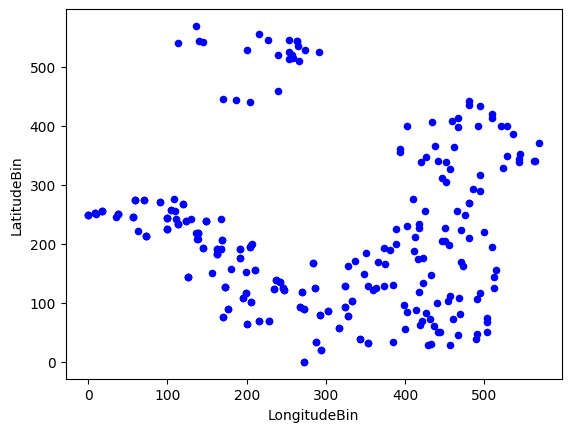

In [ ]:
# plot LongitudeBin vs LatitudeBin scatter plot
dfRain.plot.scatter(x='LongitudeBin', y='LatitudeBin', c='blue', colormap='viridis')


In [ ]:
# save dfRain to csv
dfRain.to_csv('Data/FinalFeature.csv', index=False)

In [ ]:
fireWeatherTable = "Data/FireWeather.csv"
dfFireWeather = pd.read_csv(fireWeatherTable)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
# randomly select 6 years from 2010-2019 for training
dfTrain = dfEval[dfEval['YEAR'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016])]
dfValidate = dfEval[dfEval['YEAR'].isin([2017, 2018])]
dfTest = dfEval[dfEval['YEAR'].isin([2019, 2020])]

In [ ]:
# Store our random selection, run once
# randomTrain = "RandomTrain"
# dfTrain.to_sql(randomTrain, db_push_con, if_exists='replace', index=False)

# randomTest = "RandomTest"
# dfTest.to_sql(randomTest, db_push_con, if_exists='replace', index=False)

# randomValidate = "RandomValidate"
# dfValidate.to_sql(randomValidate, db_push_con, if_exists='replace', index=False)

In [ ]:
trainStats = tfdv.generate_statistics_from_dataframe(dfTrain)

In [ ]:
tfdv.visualize_statistics(trainStats)


In [ ]:
schema = tfdv.infer_schema(statistics=trainStats)
tfdv.display_schema(schema=schema)


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


In [ ]:
dfTrainScaled = dfTrain.copy(deep=True)

In [ ]:
dfTrainScaled['SIZE_HA'] = np.log(dfTrainScaled['SIZE_HA'])
# regularize y values using z score
dfTrainScaled = (dfTrainScaled - dfTrainScaled.mean()) / dfTrainScaled.std()
# set max value to 3 zscore
dfTrainScaled[dfTrainScaled > 3] = 3
# set min value to -3 zscore
dfTrainScaled[dfTrainScaled < -3] = -3

# shift the wole train set to be positive
dfTrainScaled = dfTrainScaled + 3

In [ ]:
trainStats2 = tfdv.generate_statistics_from_dataframe(dfTrainScaled)
tfdv.visualize_statistics(trainStats2)

In [ ]:
dfTemp = pd.DataFrame()
dfTemp['SIZE_HA'] = dfTrainScaled['SIZE_HA'].copy(deep=True)
# categorize size_ha into 4 classes by quantile
dfTrainScaled['SIZE_BIN'] = pd.qcut(dfTemp['SIZE_HA'], 4, labels=False)

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(dfTrainScaled.drop(columns=['SIZE_HA']), dfTrainScaled['SIZE_BIN'])

In [ ]:

print(dfTrainScaled.count())
print(dfTrainScaled.isna().sum().sum())
print(dfTrainScaled.dtypes)

In [ ]:
print(dfTrainScaled['ElevationM'].describe())
print(dfTrainScaled['28daySumMaxTemp'].describe())

In [ ]:
C = 1  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C, decision_function_shape='ovo'),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, decision_function_shape='ovo'),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C, decision_function_shape='ovo'),
)
dfTemp = pd.DataFrame()
dfTemp['28daySumMaxTemp'] = dfTrainScaled['28daySumMaxTemp'].copy(deep=True)
dfTemp['28daySumHumidity'] = dfTrainScaled['28daySumHumidity'].copy(deep=True)

models = (clf.fit(dfTemp, dfTrainScaled['SIZE_BIN']) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(19.20, 10.80))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

X0 = dfTemp['28daySumMaxTemp'] 
X1 = dfTemp['28daySumHumidity']

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        dfTemp,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=['28dayTemp', 'Humidity'],
        ylabel="SIZE_BIN",
    )
    ax.scatter(X0, X1, c=dfTrainScaled['SIZE_BIN'], cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()